Performance (nodes_visited)
Simple Backtracking: 31
MRV+LCV: 30
MRV+LCV+AC3: 30


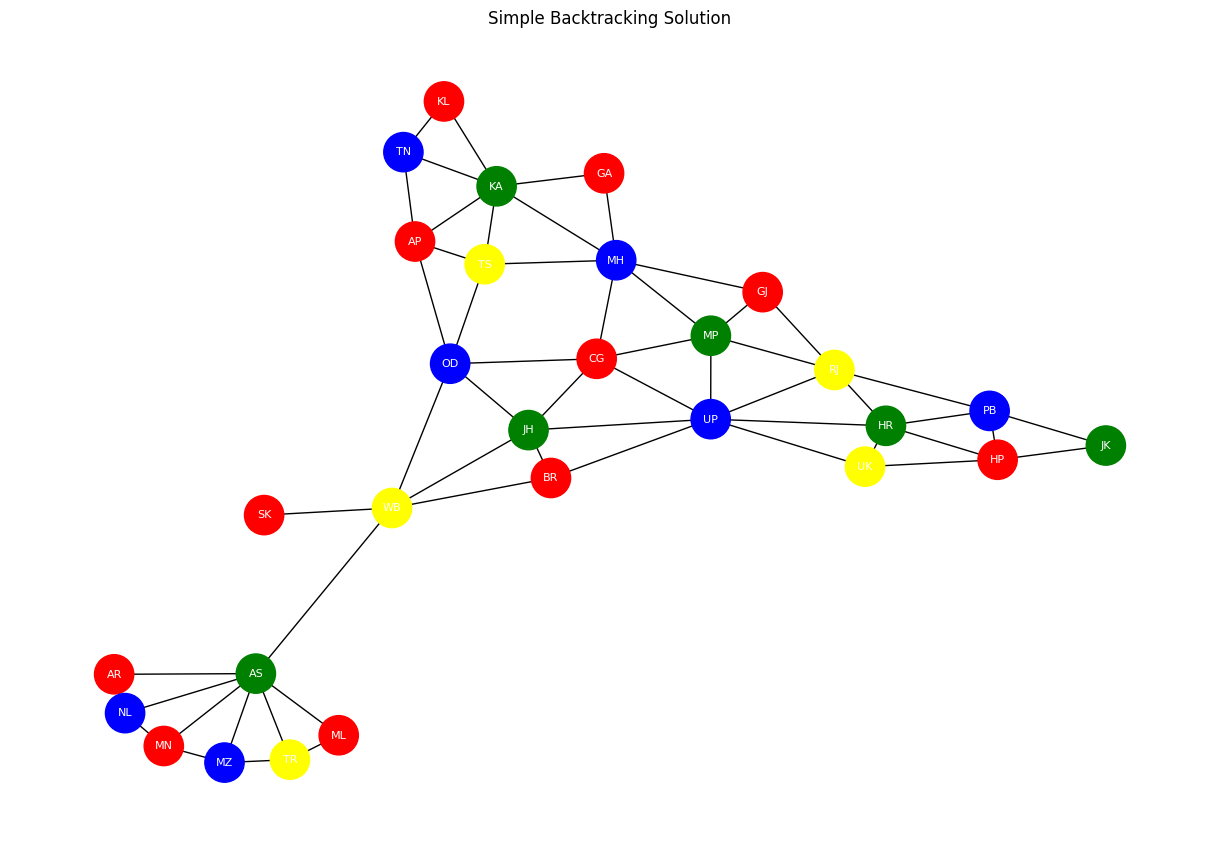

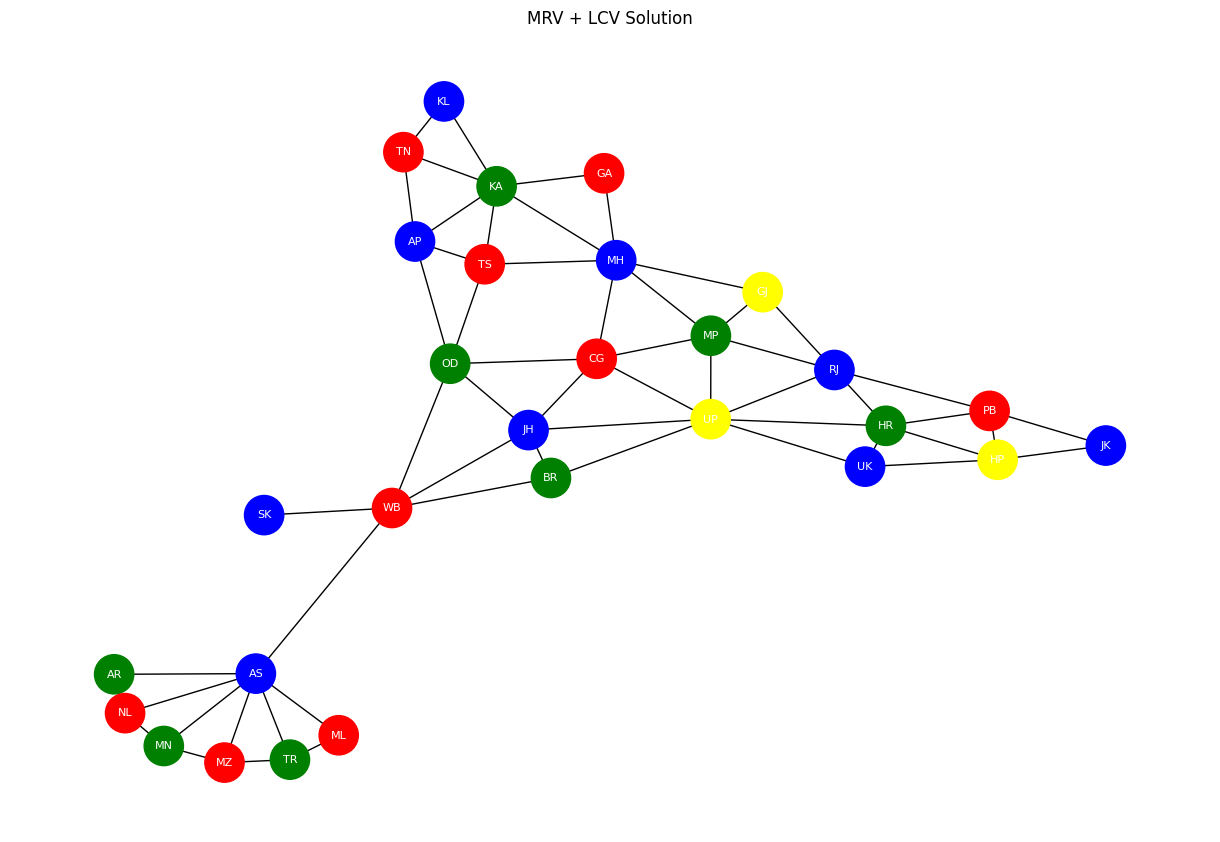

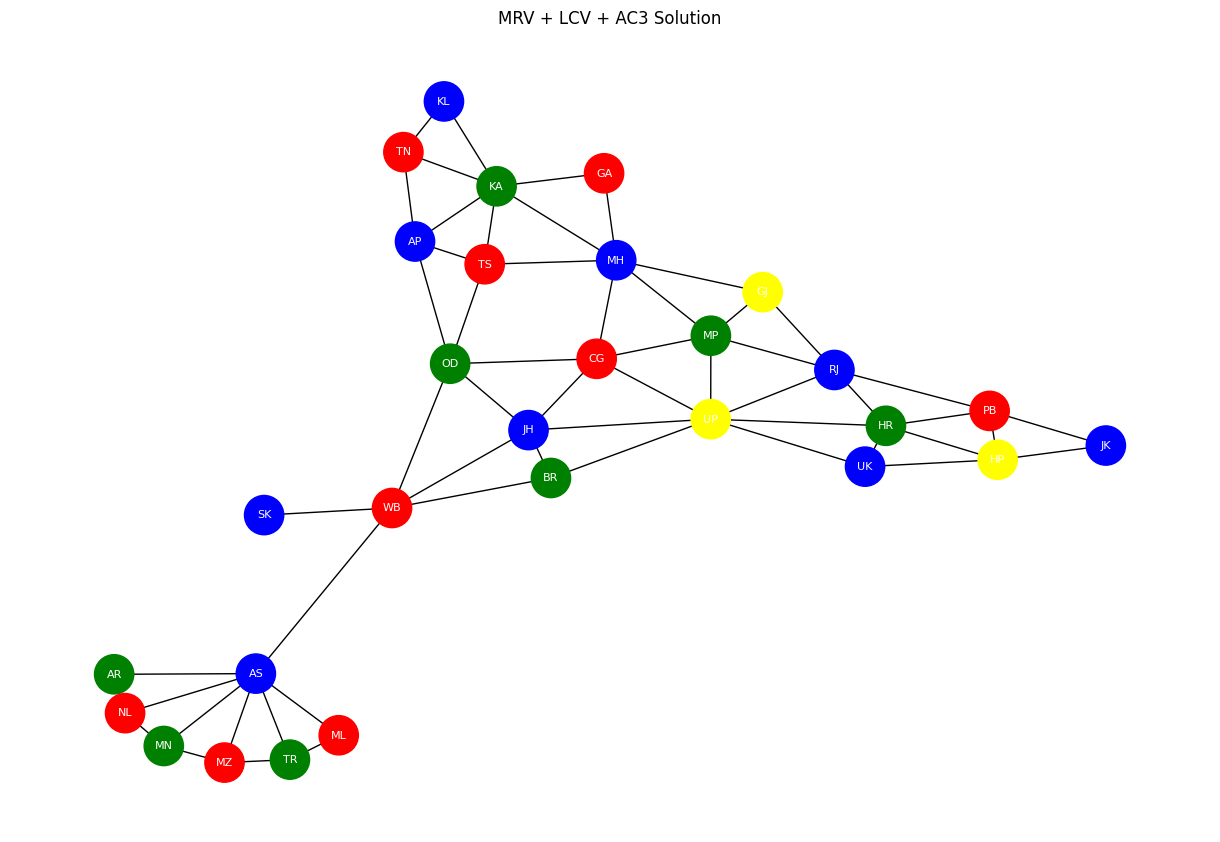

In [16]:
import copy
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt

ADJACENCY = {
    "AP": ["TS","OD","TN","KA"], "AR": ["AS","NL"], "AS": ["AR","NL","ML","TR","MZ","MN","WB"],
    "BR": ["UP","JH","WB"], "CG": ["UP","JH","OD","MH"], "GA": ["MH","KA"], "GJ": ["MH","RJ"],
    "HR": ["PB","HP","UK","RJ"], "HP": ["JK","PB","HR","UK"], "JH": ["BR","UP","CG","OD","WB"],
    "KA": ["MH","AP","TS","TN","KL","GA"], "KL": ["KA","TN"], "MP": ["RJ","UP","CG","MH","GJ"],
    "MH": ["GJ","MP","CG","TS","KA","GA"], "MN": ["AS","MZ","NL"], "ML": ["AS","TR"],
    "MZ": ["AS","MN","TR"], "NL": ["AR","AS","MN"], "OD": ["WB","JH","CG","AP","TS"],
    "PB": ["JK","HP","HR","RJ"], "RJ": ["PB","HR","MP","GJ","UP"], "SK": ["WB"],
    "TN": ["AP","KA","KL"], "TS": ["MH","KA","AP","OD"], "TR": ["AS","ML","MZ"],
    "UP": ["UK","HR","RJ","MP","CG","JH","BR"], "UK": ["HP","HR","UP"], "WB": ["BR","JH","OD","AS","SK"],
    "JK": []
}

# Ensure symmetric adjacency
for node, neighbors in list(ADJACENCY.items()):
    for neighbor in neighbors:
        if neighbor not in ADJACENCY:
            ADJACENCY[neighbor] = []
        if node not in ADJACENCY[neighbor]:
            ADJACENCY[neighbor].append(node)

COLOR_OPTIONS = ['Red','Green','Blue','Yellow']

class StatsCounter:
    def __init__(self):
        self.nodes_visited = 0
        self.assignments_made = 0

def apply_ac3(domains, adjacency):
    queue = deque((xi, xj) for xi in adjacency for xj in adjacency[xi])
    domains = copy.deepcopy(domains)
    while queue:
        xi, xj = queue.popleft()
        revised = False
        for val in list(domains[xi]):
            if not any(b != val for b in domains[xj]):
                domains[xi].remove(val)
                revised = True
        if revised:
            if not domains[xi]:
                return False, domains
            for xk in adjacency[xi]:
                if xk != xj:
                    queue.append((xk, xi))
    return True, domains

def choose_mrv_variable(unassigned_vars, domains):
    return min(unassigned_vars, key=lambda v: (len(domains[v]), v))

def order_lcv_values(variable, domains, adjacency):
    return [v for _, v in sorted(
        ((sum(val in domains[neighbor] for neighbor in adjacency[variable]), val) for val in domains[variable]),
        key=lambda x: (x[0], x[1])
    )]

def simple_backtracking(var_list, domains, adjacency, stats):
    assignment = {}
    def recursive_backtrack(index):
        stats.nodes_visited += 1
        if index == len(var_list):
            return dict(assignment)
        var = var_list[index]
        for val in domains[var]:
            stats.assignments_made += 1
            if all(assignment.get(neighbor) != val for neighbor in adjacency[var]):
                assignment[var] = val
                result = recursive_backtrack(index + 1)
                if result:
                    return result
                del assignment[var]
        return None
    return recursive_backtrack(0)

def backtrack_with_mrv_lcv(domains_original, adjacency, enable_ac3=False, debug_trace=False):
    domains = copy.deepcopy(domains_original)
    stats = StatsCounter()
    assignment = {}
    unassigned = set(domains.keys())

    if enable_ac3:
        valid, domains = apply_ac3(domains, adjacency)
        if not valid:
            return None, stats, []

    def recursive_helper(domains, unassigned):
        stats.nodes_visited += 1
        if not unassigned:
            return dict(assignment)

        var = choose_mrv_variable(unassigned, domains)
        ordered_values = order_lcv_values(var, domains, adjacency)

        if debug_trace:
            print(f"MRV selected: {var}, LCV order: {ordered_values}")

        for val in ordered_values:
            stats.assignments_made += 1
            if all(assignment.get(neighbor) != val for neighbor in adjacency[var]):
                assignment[var] = val
                unassigned.remove(var)
                new_domains = copy.deepcopy(domains)
                new_domains[var] = [val]
                for neighbor in adjacency[var]:
                    if val in new_domains[neighbor]:
                        new_domains[neighbor] = [v for v in new_domains[neighbor] if v != val]

                if enable_ac3:
                    valid, new_domains = apply_ac3(new_domains, adjacency)
                    if not valid:
                        unassigned.add(var)
                        del assignment[var]
                        continue

                result = recursive_helper(new_domains, unassigned)
                if result:
                    return result

                unassigned.add(var)
                del assignment[var]

        return None

    return recursive_helper(domains, unassigned), stats, []

# --- Visualization ---
def plot_solution(solution, graph_title):
    G = nx.Graph()
    for node, neighbors in ADJACENCY.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    node_colors = [solution.get(node, 'Gray') for node in G.nodes()]
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12,8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors,
            node_size=800, font_size=8, font_color="white", edge_color="black")
    plt.title(graph_title)
    plt.show()

def main():
    initial_domains = {v: COLOR_OPTIONS[:] for v in ADJACENCY}
    variables_ordered = sorted(ADJACENCY.keys())

    stats_simple = StatsCounter()
    solution_simple = simple_backtracking(variables_ordered, initial_domains, ADJACENCY, stats_simple)

    solution_mrv, stats_mrv, _ = backtrack_with_mrv_lcv(initial_domains, ADJACENCY, enable_ac3=False)
    solution_ac3, stats_ac3, _ = backtrack_with_mrv_lcv(initial_domains, ADJACENCY, enable_ac3=True)

    print("Performance (nodes_visited)")
    print(f"Simple Backtracking: {stats_simple.nodes_visited}")
    print(f"MRV+LCV: {stats_mrv.nodes_visited}")
    print(f"MRV+LCV+AC3: {stats_ac3.nodes_visited}")

    plot_solution(solution_simple, "Simple Backtracking Solution")
    plot_solution(solution_mrv, "MRV + LCV Solution")
    plot_solution(solution_ac3, "MRV + LCV + AC3 Solution")

if __name__ == "__main__":
    main()
